# Classification of mnist dataset

This is an example to show how you can use MapReader on non-patchified datasets

## Load
https://mapreader.readthedocs.io/en/latest/User-guide/Load.html

### Load images

In [1]:
from mapreader import loader

path2images = "./small_mnist/*.png"
my_files = loader(path2images)

100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2711.21it/s]


In [2]:
# len() shows the total number of images currently read (or sliced, see below)
print(f"Number of images: {len(my_files)}")

Number of images: 200


In [3]:
print(my_files)

#images: 200

#parents: 200
49081.png
51816.png
39566.png
24251.png
20989.png
29013.png
10692.png
58832.png
30556.png
10686.png
9294.png
...

#patches: 0



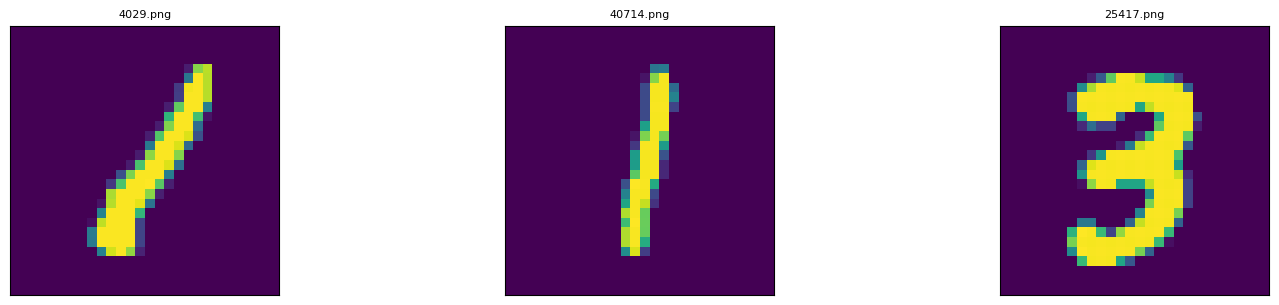

In [4]:
my_files.show_sample(num_samples=3, tree_level="parent")

100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 103.47it/s]


[<Figure size 1000x1000 with 1 Axes>]

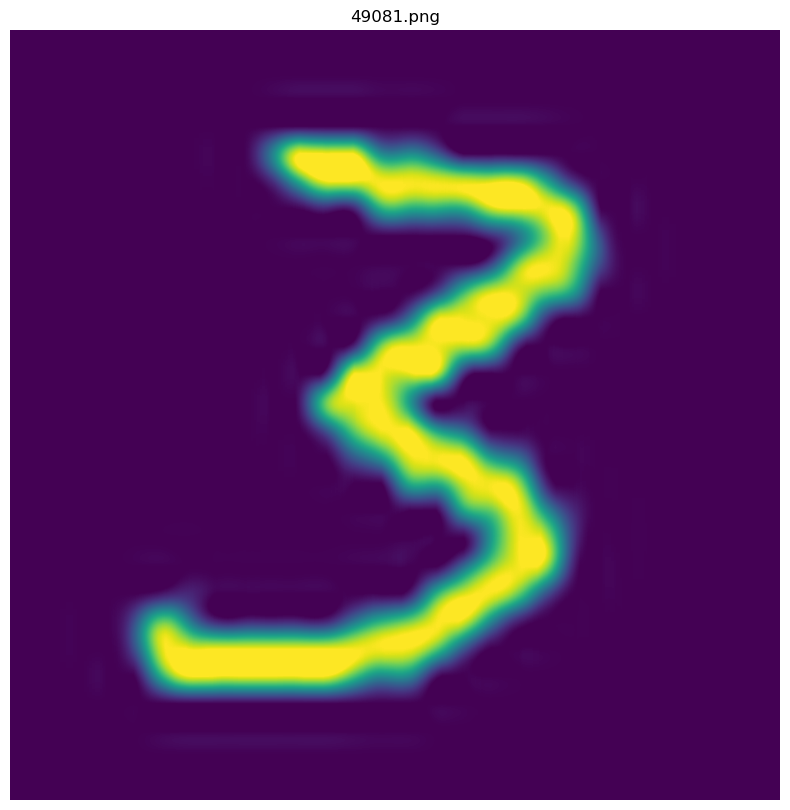

In [5]:
parent_list=my_files.list_parents()

my_files.show(parent_list[0], image_width_resolution=800)

## Annotate
https://mapreader.readthedocs.io/en/latest/User-guide/Annotate.html

In [6]:
from mapreader.annotate.utils import prepare_annotation, save_annotation

### Set up inputs

In [7]:
userID = "kasra"
annotation_tasks_file = "./annotation_tasks_mnist.yaml"
task = "mnist"
annotation_set = "task_mnist"

annotate = prepare_annotation(userID, 
                                task, 
                                tree_level="parent",
                                annotation_tasks_file=annotation_tasks_file,
                                annotation_set=annotation_set,
                                sortby="mean",
                                min_alpha_channel=0.01,
                                xoffset=50,
                                yoffset=50,
                                context_image=True,
                                list_shortcuts=["1", "3"]
                               )

100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2907.77it/s]

Number of already annotated images: 164
Number of images to be annotated (total): 36
[WARNING] could not find mean_pixel_R in columns.
Number of images to annotate (current batch): 36


### Annotate images and save annotations

In [8]:
annotate

Annotation(canvas=OutputCanvas(), progress=Progress(atoms=[<ipyannotate.progress.Atom object at 0x28e3a9ee0>, …

In [9]:
save_annotation(annotate, 
                userID, 
                task, 
                annotation_tasks_file=annotation_tasks_file,
                annotation_set=annotation_set)

[INFO] Save 0 new annotations to ./annotations_mnist/mnist_#kasra#.csv
[INFO] 0 labels were not already stored
[INFO] Total number of saved annotations: 164


## Classify - Train

https://mapreader.readthedocs.io/en/latest/User-guide/Classify.html

### Read annotations

In [10]:
from mapreader import AnnotationsLoader

In [11]:
annotated_images = AnnotationsLoader()

annotated_images.load("./annotations_mnist/mnist_#kasra#.csv")

[INFO] Reading "./annotations_mnist/mnist_#kasra#.csv"
[INFO] Number of annotations:   164

[INFO] Number of instances of each label (from column "label"):
        - 2:      87
        - 1:      77



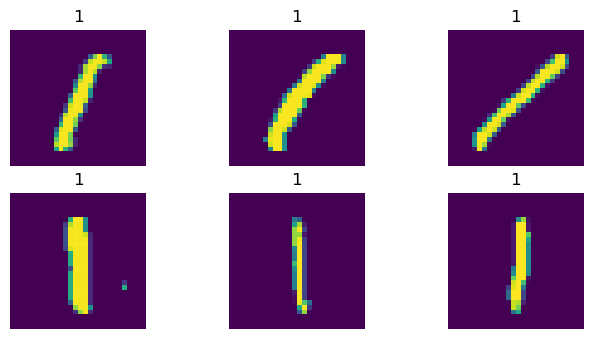

In [12]:
# show sample images for one label (label_to_show)
annotated_images.show_sample(label_to_show="1", num_samples=6)

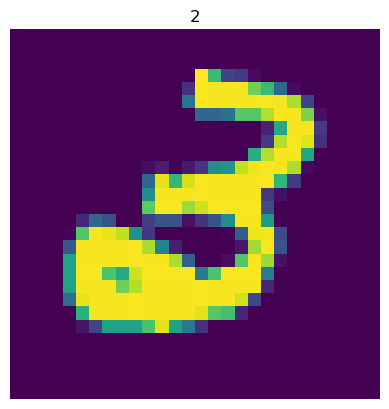

In [13]:
# show an image based on its index 
annotated_images.show_patch(patch_id="20989.png")

### Prepare datasets and dataloaders

In [14]:
annotated_images.create_datasets(frac_train=0.7, 
                                   frac_val=0.2, 
                                   frac_test=0.1)

[INFO] Number of annotations in each set:
        - Train:        114
        - Validate:     33
        - Test:         17


In [15]:
dataloaders = annotated_images.create_dataloaders(batch_size=8, sampler="default")

[INFO] Using default sampler.


### Set up `ClassifierContainer`

### Load a (pretrained) PyTorch model and combine with dataloaders

In [16]:
from mapreader import ClassifierContainer

In [38]:
my_classifier = ClassifierContainer(model="resnet18", 
                                    labels_map={0: "3", 1: "1"},
                                    dataloaders=dataloaders
                                    )

[INFO] Device is set to cpu
[INFO] Loaded "train" with 114 items.
[INFO] Loaded "val" with 33 items.
[INFO] Loaded "test" with 17 items.
[INFO] Loaded "all_mnist" with 200 items.
[INFO] Initializing model.


In [39]:
my_classifier.model_summary()

Layer (type:depth-idx)                   Output Shape              Output Shape              Param #
ResNet                                   [8, 2]                    [8, 2]                    --
├─Conv2d: 1-1                            [8, 64, 112, 112]         [8, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         [8, 64, 112, 112]         128
├─ReLU: 1-3                              [8, 64, 112, 112]         [8, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [8, 64, 56, 56]           [8, 64, 56, 56]           --
├─Sequential: 1-5                        [8, 64, 56, 56]           [8, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [8, 64, 56, 56]           [8, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]           [8, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]           [8, 64, 56, 56]           128
│    │    └─ReLU: 3-3     

### Set up criterion, optimizer and scheduler

In [40]:
my_classifier.add_criterion("cross-entropy")

[INFO] Using "CrossEntropyLoss()" as criterion.


In [41]:
params_to_optimize = my_classifier.generate_layerwise_lrs(min_lr=1e-4, max_lr=1e-3, spacing='geomspace')

In [42]:
my_classifier.initialize_optimizer(params2optimize=params_to_optimize)

In [43]:
my_classifier.initialize_scheduler()

### Train/fine-tune a model

In [44]:
my_classifier.train(num_epochs=5, 
                   save_model_dir="./models_mnist", 
                   tensorboard_path="tboard_mnist", 
                   tmp_file_save_freq=2,
                   remove_after_load=False,
                   print_info_batch_freq=5)

[INFO] Each training step will pass: ['train', 'val'].
2023-06-05 10:32:24 599-JY5FK6 [INFO] train    -- 1/5 --      8/114 (  7.0% ) -- Loss: 0.596
2023-06-05 10:32:26 599-JY5FK6 [INFO] train    -- 1/5 --     48/114 ( 42.1% ) -- Loss: 0.014
2023-06-05 10:32:27 599-JY5FK6 [INFO] train    -- 1/5 --     88/114 ( 77.2% ) -- Loss: 0.001
2023-06-05 10:32:28 599-JY5FK6 [INFO] train    -- 1/5 -- Loss: 0.342; F_macro: 92.97; R_macro: 92.97
2023-06-05 10:32:28 599-JY5FK6 [INFO] val      -- 1/5 --       8/33 ( 24.2% ) -- Loss: 0.802
2023-06-05 10:32:28 599-JY5FK6 [INFO] val      -- 1/5 -- Loss: 0.556; F_macro: 90.60; R_macro: 90.00

2023-06-05 10:32:29 599-JY5FK6 [INFO] train    -- 2/5 --      8/114 (  7.0% ) -- Loss: 0.618
2023-06-05 10:32:30 599-JY5FK6 [INFO] train    -- 2/5 --     48/114 ( 42.1% ) -- Loss: 0.002
2023-06-05 10:32:31 599-JY5FK6 [INFO] train    -- 2/5 --     88/114 ( 77.2% ) -- Loss: 0.059
2023-06-05 10:32:32 599-JY5FK6 [INFO] train    -- 2/5 -- Loss: 0.092; F_macro: 97.37; R_mac

In [45]:
list(my_classifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

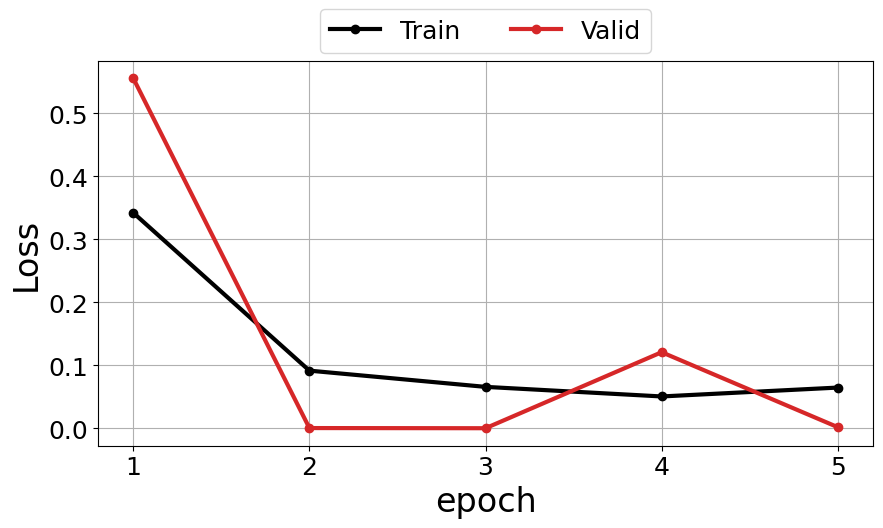

In [46]:
my_classifier.plot_metric(y_axis=["epoch_loss_train", "epoch_loss_val"],
                         y_label="Loss",
                         legends=["Train", "Valid"],
                         colors=["k", "tab:red"])

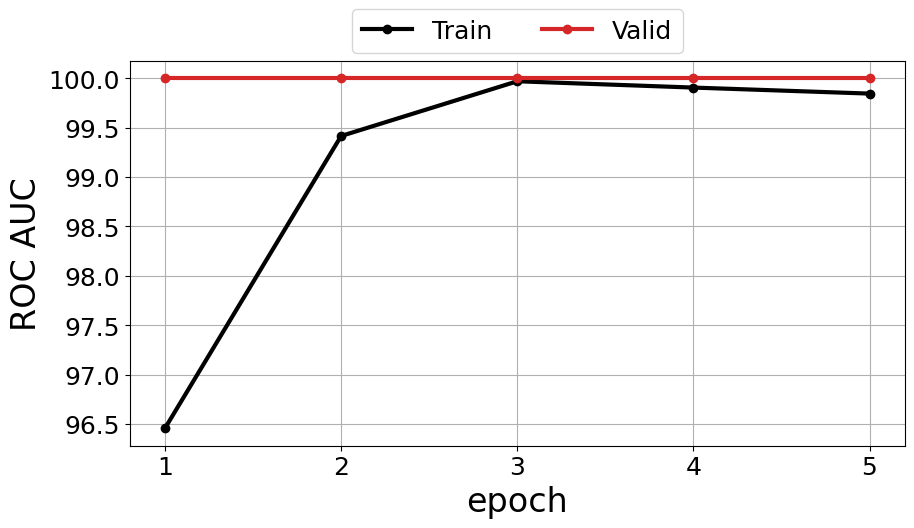

In [47]:
my_classifier.plot_metric(y_axis=["epoch_rocauc_macro_train", "epoch_rocauc_macro_val"],
                         y_label="ROC AUC",
                         legends=["Train", "Valid"],
                         colors=["k", "tab:red"])

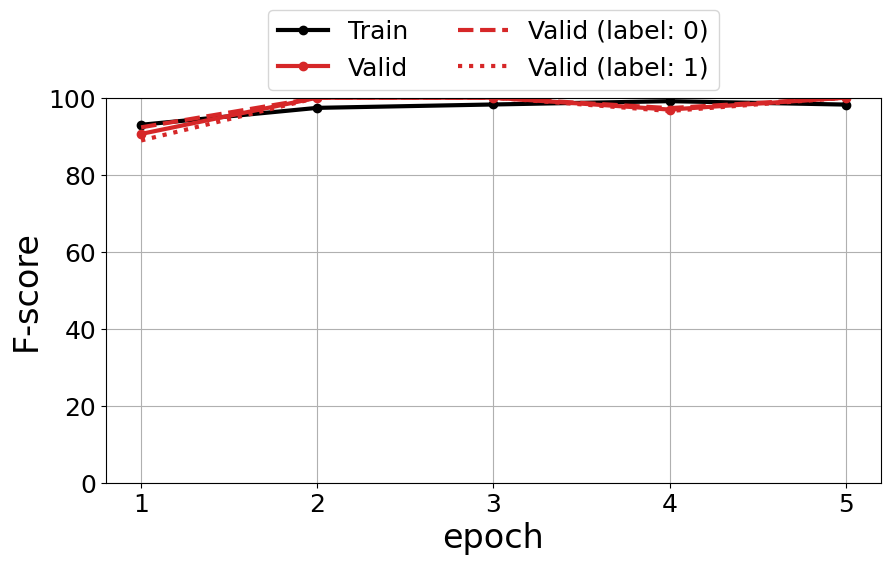

In [48]:
my_classifier.plot_metric(y_axis=["epoch_fscore_macro_train", 
                                 "epoch_fscore_macro_val", 
                                 "epoch_fscore_0_val", 
                                 "epoch_fscore_1_val"],
                         y_label="F-score",
                         legends=["Train", 
                                  "Valid", 
                                  "Valid (label: 0)",
                                  "Valid (label: 1)",],
                         colors=["k", "tab:red", "tab:red", "tab:red"],
                         styles=["-", "-", "--", ":"],
                         markers=["o", "o", "", ""],
                         plt_yrange=[0, 100])

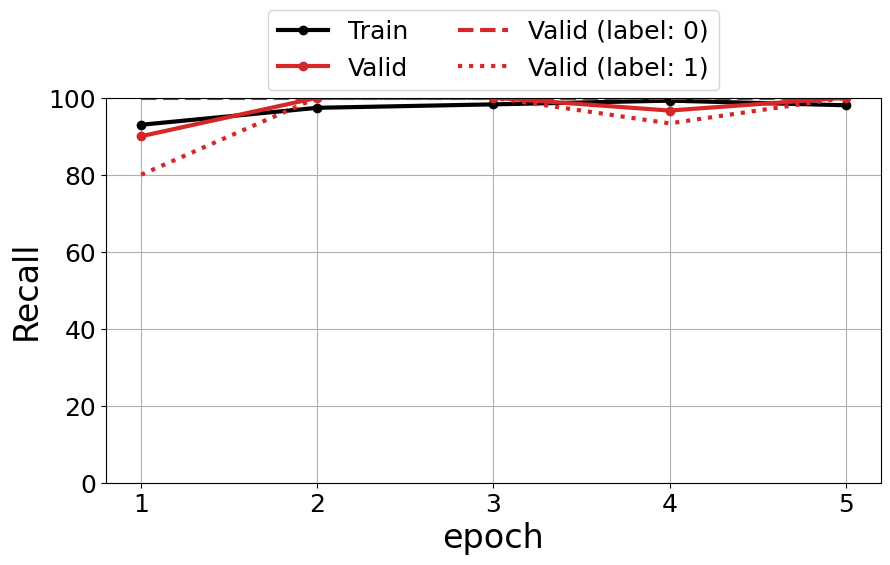

In [49]:
my_classifier.plot_metric(y_axis=["epoch_recall_macro_train", 
                                 "epoch_recall_macro_val", 
                                 "epoch_recall_0_val", 
                                 "epoch_recall_1_val"],
                         y_label="Recall",
                         legends=["Train", 
                                  "Valid", 
                                  "Valid (label: 0)",
                                  "Valid (label: 1)",],
                         colors=["k", "tab:red", "tab:red", "tab:red"],
                         styles=["-", "-", "--", ":"],
                         markers=["o", "o", "", ""],
                         plt_yrange=[0, 100])

## Classify - Infer

https://mapreader.readthedocs.io/en/latest/User-guide/Classify.html

### Create dataset with all mnist data and add to ``ClassifierContainer``

In [50]:
#create dataframe from MapImages object
parent_df, patch_df = my_files.convert_images()
parent_df.head()

,parent_id,image_path,shape
image_id,,,
49081.png,None,/Users/rwood/LwM/MapReader/worked_examples/non...,"(28, 28)"
51816.png,None,/Users/rwood/LwM/MapReader/worked_examples/non...,"(28, 28)"
39566.png,None,/Users/rwood/LwM/MapReader/worked_examples/non...,"(28, 28)"
24251.png,None,/Users/rwood/LwM/MapReader/worked_examples/non...,"(28, 28)"
20989.png,None,/Users/rwood/LwM/MapReader/worked_examples/non...,"(28, 28)"


In [51]:
from mapreader import PatchDataset

In [52]:
data = PatchDataset(parent_df, transform="val")

In [53]:
my_classifier.load_dataset(data, set_name="all_mnist")

### Infer labels

In [54]:
my_classifier.inference("all_mnist")

[INFO] Each training step will pass: ['all_mnist'].
2023-06-05 10:32:46 599-JY5FK6 [INFO] all_mnist -- 6/6 --     16/200 (  8.0% ) -- 
2023-06-05 10:32:49 599-JY5FK6 [INFO] all_mnist -- 6/6 --     96/200 ( 48.0% ) -- 
2023-06-05 10:32:52 599-JY5FK6 [INFO] all_mnist -- 6/6 --    176/200 ( 88.0% ) -- 
[INFO] Total time: 0m 7s


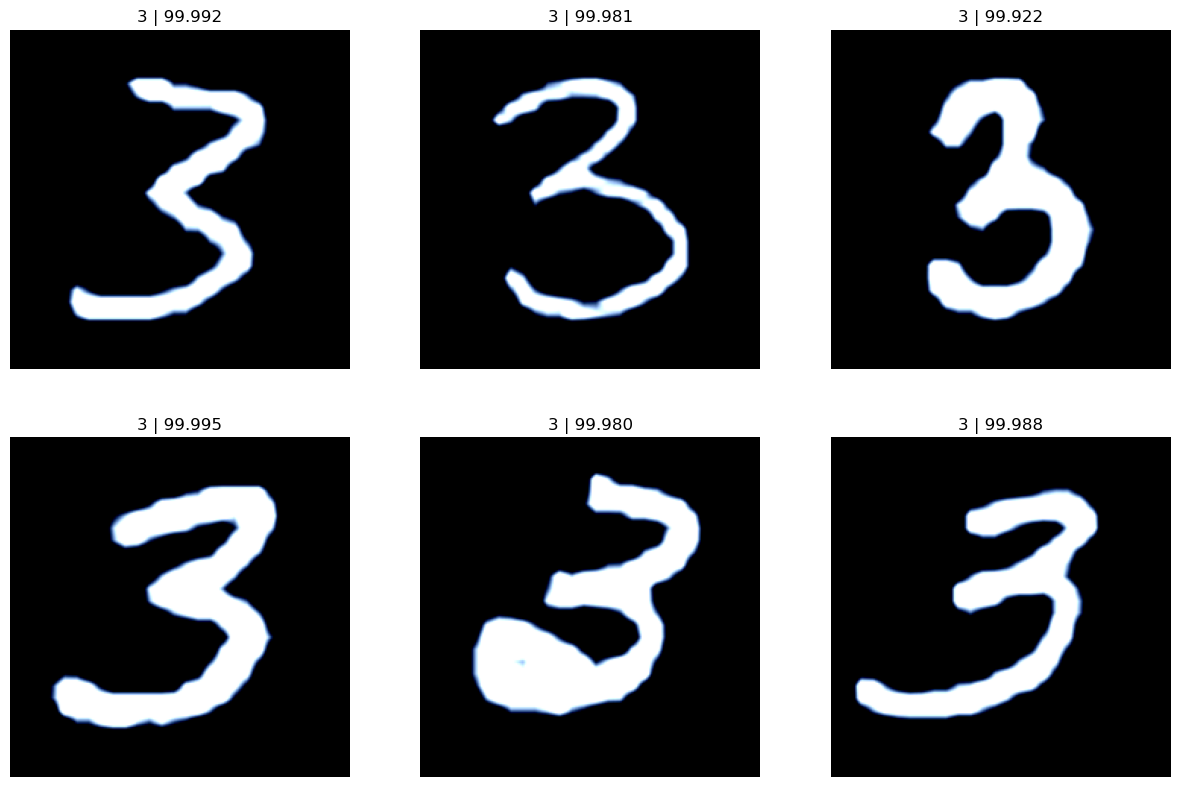

In [55]:
my_classifier.show_inference_sample_results(label="3", set_name="all_mnist", min_conf=99)

### Add predictions to dataframe

In [56]:
predictions_df = data.patch_df

In [57]:
import numpy as np
import pandas as pd

predictions_df['predicted_label'] = my_classifier.pred_label
predictions_df['pred'] = my_classifier.pred_label_indices
predictions_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

predictions_df.head()

,parent_id,image_path,shape,predicted_label,pred,conf
image_id,,,,,,
49081.png,None,/Users/rwood/LwM/MapReader/worked_examples/non...,"(28, 28)",3,0,0.999915
51816.png,None,/Users/rwood/LwM/MapReader/worked_examples/non...,"(28, 28)",3,0,0.999805
39566.png,None,/Users/rwood/LwM/MapReader/worked_examples/non...,"(28, 28)",3,0,0.999222
24251.png,None,/Users/rwood/LwM/MapReader/worked_examples/non...,"(28, 28)",3,0,0.999954
20989.png,None,/Users/rwood/LwM/MapReader/worked_examples/non...,"(28, 28)",3,0,0.999804


In [58]:
predictions_df.to_csv("./predictions_df.csv", sep=",", index_label="image_id")